# Classification of breast cancer

https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+%28Diagnostic%29

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn.ensemble
import sklearn.feature_selection
import sklearn.metrics
import sklearn.model_selection
import sklearn.preprocessing

sns.set_theme(context="paper", style="ticks", font_scale=2)

## Load data

In [2]:
df = pd.read_csv("TCGA-PANCAN-HiSeq-801x20531/data.csv")
df = df.rename(columns={"Unnamed: 0": "sample"})
df = df.set_index("sample")
df.head()

,?|100130426,?|100133144,?|100134869,?|10357,?|10431,?|136542,?|155060,?|26823,?|280660,?|317712,...,ZXDA|7789,ZXDB|158586,ZXDC|79364,ZYG11A|440590,ZYG11B|79699,ZYX|7791,ZZEF1|23140,ZZZ3|26009,psiTPTE22|387590,tAKR|389932
sample,,,,,,,,,,,,,,,,,,,,,
sample_0,0.0,2.017209,3.265527,5.478487,10.431999,0,7.175175,0.591871,0.0,0.0,...,4.926711,8.210257,9.723516,7.220030,9.119813,12.003135,9.650743,8.921326,5.286759,0.0
sample_1,0.0,0.592732,1.588421,7.586157,9.623011,0,6.816049,0.000000,0.0,0.0,...,4.593372,7.323865,9.740931,6.256586,8.381612,12.674552,10.517059,9.397854,2.094168,0.0
sample_2,0.0,3.511759,4.327199,6.881787,9.870730,0,6.972130,0.452595,0.0,0.0,...,5.125213,8.127123,10.908640,5.401607,9.911597,9.045255,9.788359,10.090470,1.683023,0.0
sample_3,0.0,3.663618,4.507649,6.659068,10.196184,0,7.843375,0.434882,0.0,0.0,...,6.076566,8.792959,10.141520,8.942805,9.601208,11.392682,9.694814,9.684365,3.292001,0.0
sample_4,0.0,2.655741,2.821547,6.539454,9.738265,0,6.566967,0.360982,0.0,0.0,...,5.996032,8.891425,10.373790,7.181162,9.846910,11.922439,9.217749,9.461191,5.110372,0.0


In [3]:
labels = pd.read_csv("TCGA-PANCAN-HiSeq-801x20531/labels.csv")
labels = labels["Class"].values.ravel()
labels[:5]

array(['PRAD', 'LUAD', 'PRAD', 'PRAD', 'BRCA'], dtype=object)

## Visualize distribution of data

<AxesSubplot:ylabel='count'>

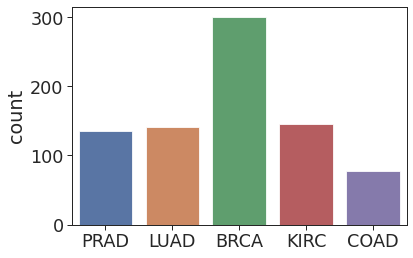

In [4]:
sns.countplot(x=labels)

## Sample

### Random sampling

<AxesSubplot:xlabel='value', ylabel='count'>

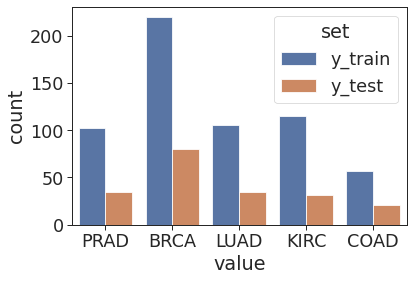

In [5]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    df,
    labels,
    train_size=0.75,
    random_state=42,
)

sns.countplot(
    data=pd.DataFrame(data=[y_train, y_test], index=["y_train", "y_test"])
    .T.melt(var_name="set")
    .dropna(),
    x="value",
    hue="set",
)

### Oversample the rarer classes

In [6]:
# %pip install --no-cache-dir imbalanced-learn

In [7]:
from collections import Counter
from imblearn.over_sampling import RandomOverSampler

In [8]:
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(df, labels)
print(sorted(Counter(y_resampled).items()))

[('BRCA', 300), ('COAD', 300), ('KIRC', 300), ('LUAD', 300), ('PRAD', 300)]


## Train baseline random forest

<AxesSubplot:xlabel='value', ylabel='count'>

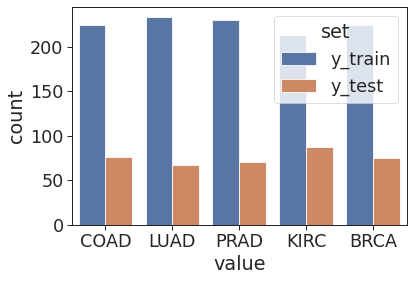

In [9]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X_resampled,
    y_resampled,
    train_size=0.75,
    random_state=42,
)

sns.countplot(
    data=pd.DataFrame(data=[y_train, y_test], index=["y_train", "y_test"])
    .T.melt(var_name="set")
    .dropna(),
    x="value",
    hue="set",
)

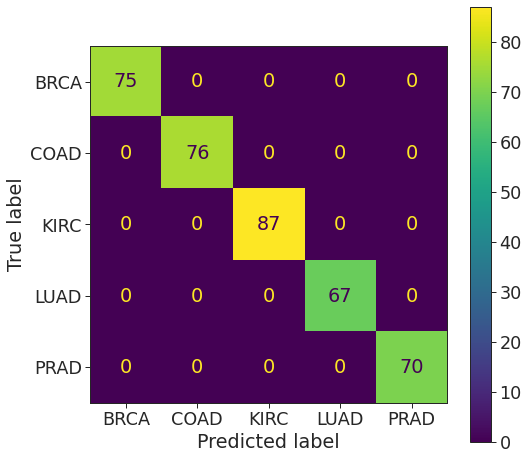

In [10]:
clf = sklearn.ensemble.RandomForestClassifier(random_state=42, class_weight=None)
clf.fit(X_train, y_train)

_, ax = plt.subplots(figsize=(8, 8))
sklearn.metrics.ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test, ax=ax)

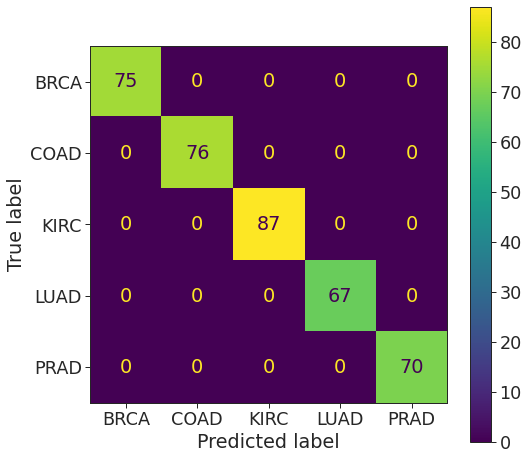

In [11]:
clf = sklearn.ensemble.RandomForestClassifier(random_state=42, class_weight=None)
clf.fit(X_train, y_train)

_, ax = plt.subplots(figsize=(8, 8))
sklearn.metrics.ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test, ax=ax)

### Plot most important genes

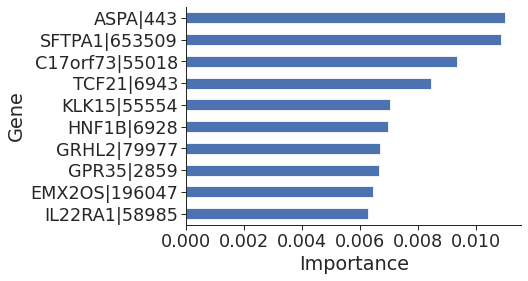

In [12]:
feat_importances = pd.Series(clf.feature_importances_, index=df.columns)
feat_importances.nlargest(10).plot(kind='barh').invert_yaxis()
plt.ylabel("Gene")
plt.xlabel("Importance")
sns.despine()
plt.show()

## Find most essential genes for training

In [13]:
clf = sklearn.ensemble.RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [14]:
sfm = sklearn.feature_selection.SelectFromModel(clf).fit(X_train, y_train)

In [15]:
# Number of features selected
sfm.get_support().sum()

1111

In [16]:
# Takes a long time to run
# sfs_forward = sklearn.feature_selection.SequentialFeatureSelector(clf).fit(X_train, y_train)

## Cross validation

In [17]:
from sklearn.model_selection import cross_val_score

In [18]:
clf = sklearn.ensemble.RandomForestClassifier(random_state=42)
cv_scores = cross_val_score(clf, X=df, y=labels, cv=5, scoring="f1_macro")
cv_scores

array([0.98957618, 1.        , 1.        , 0.99471074, 1.        ])

# Try again with another ensemble

In [19]:
# %pip install --no-cache-dir xgboost

In [20]:
import xgboost as xgb

/home/jakub/Documents/bmi511/pratik/venv/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [21]:
enc = sklearn.preprocessing.LabelEncoder()
y_train_enc = enc.fit_transform(y_train)

In [ ]:
xgb_clf = xgb.XGBRFClassifier(use_label_encoder=False).fit(X_train, y_train_enc)

/home/jakub/Documents/bmi511/pratik/venv/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
